In [1]:
import torch
import segmentation_models_pytorch as smp
import datasets
import datetime
import numpy as np

from myUtils import *

In [2]:
res = 320
dataset = datasets.PlateDataset(res = res, train = True)

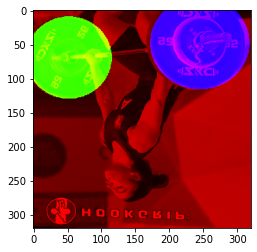

In [3]:
plot_tensor(dataset[0])

In [4]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=2,
    activation='sigmoid',
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [5]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [6]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

In [7]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=12)

In [8]:
# append to file
score = 0
optimizer.param_groups[0]['lr'] = 1e-4
for i in range(0, 125):
    print(f'\nEpoch: {i}')
    train_logs = train_epoch.run(dataloader)
    
    if train_logs['iou_score'] > score:
        torch.save(model, f'./best_model.pth')
    else:
        torch.save(model, f'./checkpoint_model.pth')

    score = train_logs['iou_score']

    with open('./train.log', 'a') as f:
        f.write(f'{i} | {datetime.datetime.now()} | {str(train_logs)}\n')

    if i == 50:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

    if i == 75:
        optimizer.param_groups[0]['lr'] = 1e-6
        print('Decrease decoder learning rate to 1e-6!')

    if i == 100:
        optimizer.param_groups[0]['lr'] = 1e-7
        print('Decrease decoder learning rate to 1e-7!')


Epoch: 0
train:   0%|          | 0/56 [00:00<?, ?it/s]

/root/workspace/tracking/venv/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


train: 100%|██████████| 56/56 [00:21<00:00,  2.62it/s, dice_loss - 0.3548, iou_score - 0.5144]

Epoch: 1
train: 100%|██████████| 56/56 [00:21<00:00,  2.66it/s, dice_loss - 0.2003, iou_score - 0.6788]

Epoch: 2
train: 100%|██████████| 56/56 [00:21<00:00,  2.66it/s, dice_loss - 0.1688, iou_score - 0.7218]

Epoch: 3
train: 100%|██████████| 56/56 [00:21<00:00,  2.65it/s, dice_loss - 0.1535, iou_score - 0.7431]

Epoch: 4
train: 100%|██████████| 56/56 [00:21<00:00,  2.64it/s, dice_loss - 0.1477, iou_score - 0.751] 

Epoch: 5
train: 100%|██████████| 56/56 [00:21<00:00,  2.63it/s, dice_loss - 0.1481, iou_score - 0.7517]

Epoch: 6
train: 100%|██████████| 56/56 [00:21<00:00,  2.65it/s, dice_loss - 0.1421, iou_score - 0.7603] 

Epoch: 7
train: 100%|██████████| 56/56 [00:21<00:00,  2.63it/s, dice_loss - 0.1284, iou_score - 0.7798]

Epoch: 8
train: 100%|██████████| 56/56 [00:21<00:00,  2.65it/s, dice_loss - 0.1243, iou_score - 0.7866]

Epoch: 9
train: 100%|██████████| 56/56 [00:21<00:00,  2.60it/s,

In [11]:
model = torch.load(f'./best_model.pth')

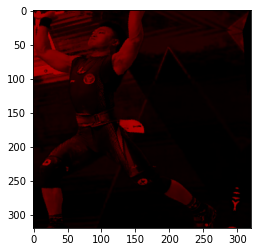

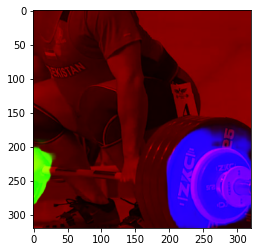

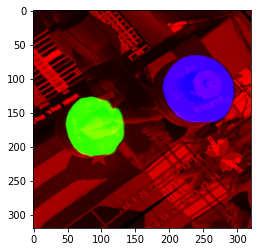

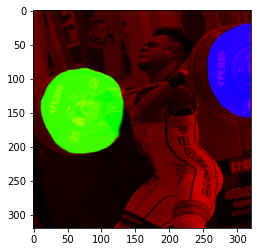

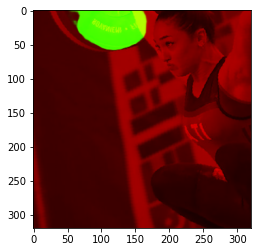

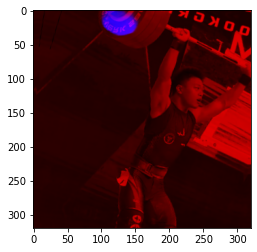

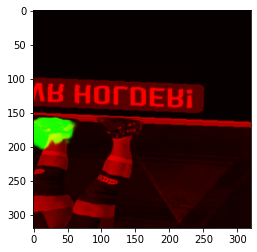

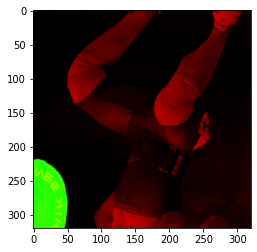

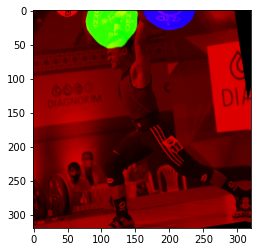

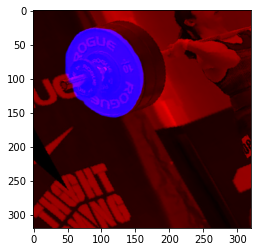

In [13]:
for i in range(10):
    rand = np.random.randint(0, len(dataset))
    plot_pred(dataset[rand][0], model)